In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import (
    ResNet50
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob

# Define the folder path
folder_path = '/content/drive/MyDrive/Tharshini/data/healthy'

# Define a list of valid image file extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tif', '.tiff']

# Use glob to get a list of all files in the folder
all_files = glob.glob(os.path.join(folder_path, '*'))

# Use a list comprehension to filter for image files
image_files = [file for file in all_files if os.path.splitext(file)[-1].lower() in valid_extensions]

# Get the count of image files
num_images = len(image_files)

print(f"Number of images in the folder: {num_images}")


Number of images in the folder: 41


In [ ]:
import os
import cv2
import numpy as np

# Define the paths to the folders containing your X-ray images for 5 classes
class_folders = [
    '/content/drive/MyDrive/Tharshini/data/Bacterial_wilt',
    '/content/drive/MyDrive/Tharshini/data/Cercospora_leaf_spot',
    '/content/drive/MyDrive/Tharshini/data/Collar_Rot',
    '/content/drive/MyDrive/Tharshini/data/Tobacco_mosanic',
    '/content/drive/MyDrive/Tharshini/data/healthy'
]

# Define the number of samples per class individually
num_samples_per_class = [10, 10, 10, 10, 40]  # Adjust as needed for each class

# Function to load and preprocess images from a folder
def load_images_from_folder(folder, num_samples):
    images = []
    count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224)) # Resize images to 224x224 pixels
            images.append(img)
            count += 1
            if count >= num_samples:
                break
    return images

# Initialize lists to store samples for each class
class_samples = []

# Load samples for each class
for i, folder_path in enumerate(class_folders):
    samples = np.array(load_images_from_folder(folder_path, num_samples_per_class[i]))
    class_samples.append(samples)

# Convert lists of samples for each class to a single NumPy array
all_samples = np.vstack(class_samples)

# Print the shape of the loaded samples
print("Shape of all samples:", all_samples.shape)


Shape of all samples: (80, 224, 224)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine samples from all classes into a single array
Data = np.vstack(class_samples)  # Assuming you followed the previous code to load samples for each class

# Create labels for each class
class_labels = []
for i, samples in enumerate(class_samples):
    class_label = np.full(len(samples), i)  # Assign a unique label to each class (0 to 4)
    class_labels.append(class_label)

# Combine labels from all classes into a single array
Label = np.concatenate(class_labels, axis=0)

# Reshape the data to match the input shape for a CNN (assuming grayscale images)
Data = Data.reshape(Data.shape[0], Data.shape[1], Data.shape[2], 1)
Data = np.repeat(Data, 3, axis=3)  # Convert to RGB format if needed

# Print the data shape
print("Data shape:", Data.shape)
print("Label shape:", Label.shape)


Data shape: (80, 224, 224, 3)
Label shape: (80,)


In [ ]:
def training_models(model_name, model_class, input_shape, data_train, labels_train, data_test,labels_test,index):

    # Define an empty dict to save results (histories and models)
    result = {}

    print(f"Training and evaluating {model_name}...")

    # Load the base model
    base_model = model_class(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)


    # The output layer
    predictions = Dense(5, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and save the related history
    checkpoint_path = "/content/drive/MyDrive/Tharshini/Model16/weights_best1.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    history = model.fit(
        x=data_train,
        y=labels_train,
        batch_size=32,
        callbacks=[cp_callback],
        epochs=50,
        validation_data=(data_test, labels_test)
    )
    # Store the history in the result dictionary
    result['history'] = history.history

    # Save the history to a CSV file
    history_df = pd.DataFrame(history.history)
    history_csv_path = f'/content/drive/MyDrive/Tharshini/Model16/Model'+str(index+1)+'/history_fold_1.csv'
    history_df.to_csv(history_csv_path, index=False)

    prediticted_classes = model.predict(data_test, batch_size=4)
    print("Predict Classes", prediticted_classes)
    print("Evaluate on test data")
    results = model.evaluate(data_test, labels_test, verbose=0)
    print("test loss, test acc:", results)

    model_best = Model(inputs=base_model.input, outputs=predictions) # Assuming creat
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model_best.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    model_best.load_weights(checkpoint_path)
    results_t = model_best.evaluate(data_test, labels_test, verbose=0)

    # Save model
    model_best.save('/content/drive/MyDrive/Tharshini/Model16/Model'+str(index+1)+'/best1.hdf5')

    return results,results_t



In [ ]:
models_1 = {
    'ResNet50': ResNet50,
}

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

# Number of splits for cross-validation
splits = 5
accuracy = np.zeros(splits)
accuracyBest = np.zeros(splits)
index = 0

kf = KFold(n_splits=splits, shuffle=True)
for model_name, model_class in models_1.items():
  for train_index, test_index in kf.split(Data):
      print("TRAIN:", train_index, "TEST:", test_index)
      print("Test label", Label[test_index])

      # Save test index
      pd.DataFrame(test_index).to_csv('/content/drive/MyDrive/Tharshini/Model16/Model'+str(index+1)+'/testindex1.csv', header=False, index=False)

      tf.keras.backend.clear_session()

      accu,accuT = training_models(model_name,model_class,(224,224,3),Data[train_index], to_categorical(Label[train_index]), Data[test_index], to_categorical(Label[test_index]), index)
      accuracy[index] = accu[1]
      accuracyBest[index] = accuT[1]
      index+=1


print(accuracy)
print("Average accuracy:", sum(accuracy) / splits)
print(accuracyBest)
print("Best Average is:", sum(accuracyBest)/splits)

TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 24 25 26
 27 28 29 30 31 32 33 34 35 37 39 40 41 43 44 45 46 49 50 54 55 56 57 58
 59 60 61 62 64 65 66 67 68 69 70 71 73 74 75 78] TEST: [ 3 14 23 36 38 42 47 48 51 52 53 63 72 76 77 79]
Test label [0 1 2 3 3 4 4 4 4 4 4 4 4 4 4 4]
Training and evaluating ResNet50...
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 3.1256 - accuracy: 0.4375 
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to /content/drive/MyDrive/Tharshini/Model16/weights_best1.hdf5
2/2 [==============================] - 16s 3s/step - loss: 3.1256 - accuracy: 0.4375 - val_loss: 5.0979 - val_accuracy: 0.1875
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 2.5670 - accuracy: 0.4062
Epoch 2: val_accuracy improved from 0.18750 to 0.81250, saving model to /content/drive/MyDrive/Tharshini/Model16/weights_best1.hdf5
2/2 [=================

In [ ]:
for model_name, model_class in models_1.items():
    base_model = model_class(include_top=False, weights='imagenet', input_shape=(224,224,3))
    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)

    x = Dense(256, activation='relu')(x)
   # x = Dense(64, activation='relu')(x)


    # The output layer
    predictions = Dense(5, activation='softmax')(x)
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    layers=model.layers
    last_conv_layer_name = None
    for layer in reversed(layers):
        if 'conv' in layer.name:
            last_conv_layer_name = layer.name
            break # Stop at the last convolutional layer before the target activation
print("Last Convolutional Layer Name:", last_conv_layer_name)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model_heat = Model(inputs=base_model.input, outputs=predictions) # Assuming create_mo
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_heat.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_heat.load_weights(r"/content/drive/MyDrive/Tharshini/Model16/weights_best1.hdf5")
model_heat.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(preds)
        # print(last_conv_layer_output.shape)
        # if pred_index is None:
        #     pred_index = tf.argmax(preds[0])
        # class_channel = preds[:, pred_index]
        class_channel = preds

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # print(grads.shape, "grads")

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # print(pooled_grads.shape, "pooledgrads")

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    # last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
      # Load the original image

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")
      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]
      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.utils.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.utils.img_to_array(jet_heatmap)
      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.utils.array_to_img(superimposed_img)
      # Save the superimposed image
      plt.imshow(superimposed_img)
      plt.show()

      return superimposed_img


1/1 [==============================] - 1s 881ms/step


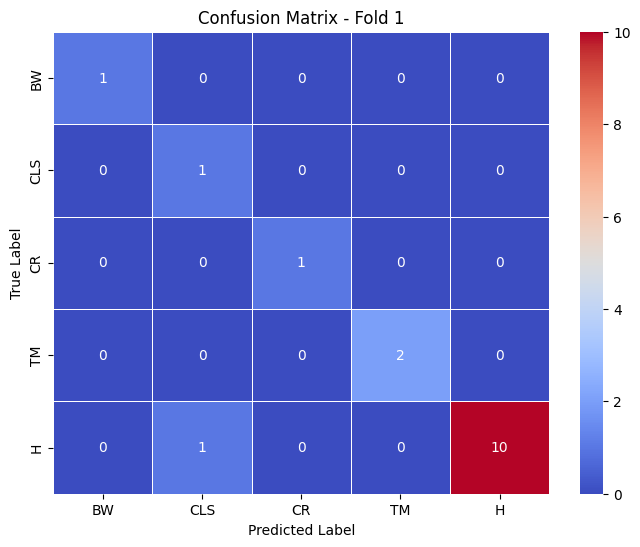

1/1 [==============================] - 0s 27ms/step


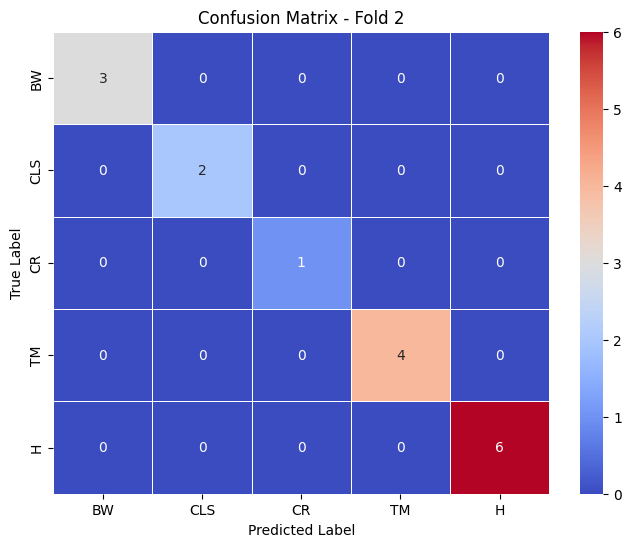

1/1 [==============================] - 0s 25ms/step


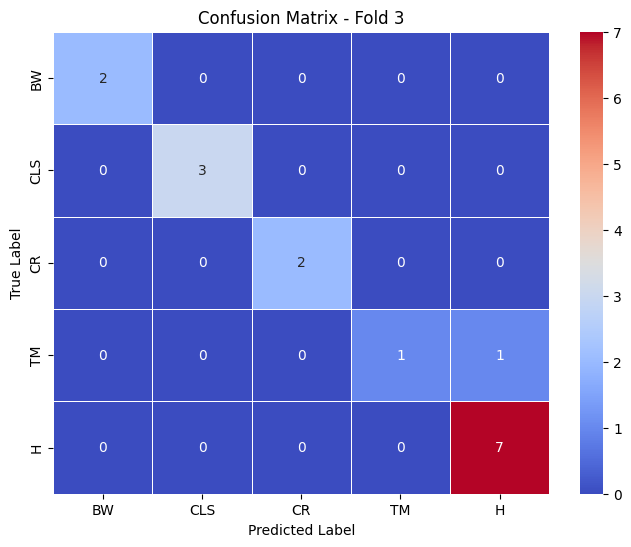

1/1 [==============================] - 0s 37ms/step


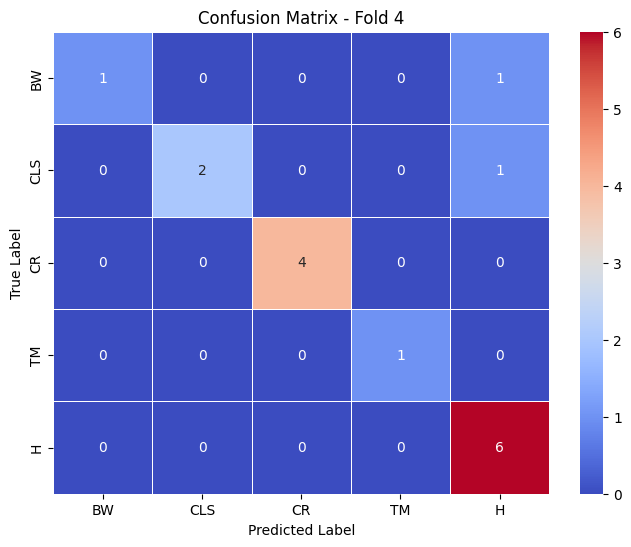

  Class  Precision    Recall  Accuracy  F1 Score
0    BW    1.00000  0.875000    0.9375  0.916667
1   CLS    0.87500  0.916667    0.9375  0.866667
2    CR    1.00000  1.000000    0.9375  1.000000
3    TM    1.00000  0.875000    0.9375  0.916667
4     H    0.90625  0.977273    0.9375  0.935714


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize arrays to store metrics for each fold
confusion_matrices = []
precisions = []
recalls = []
accuracies = []
f1_scores = []

# Define your class labels (5 classes)
class_labels = ["BW", "CLS", "CR", "TM", "H"]

# Iterate through each fold
for fold_index in range(4):

    # Load the best model for this fold
    model_path = f'/content/drive/MyDrive/Tharshini/Model16/Model{fold_index + 1}/best1.hdf5'
    model.load_weights(model_path)  # Load the model

    test_index_path = f'/content/drive/MyDrive/Tharshini/Model16/Model{fold_index + 1}/testindex1.csv'

    # Extract the test indices column from the DataFrame
    test_index = pd.read_csv(test_index_path, header=None).values.flatten().tolist()

    # Get predictions for the test data using the loaded model
    predictions = model.predict(Data[test_index])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = Label[test_index]

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    confusion_matrices.append(cm)

    # Calculate precision, recall, accuracy, and F1 score for each class
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    precisions.append(precision)
    recalls.append(recall)

    # Calculate accuracy and store it
    accuracy = accuracy_score(true_labels, predicted_labels)
    accuracies.append(accuracy)

    # Calculate F1 score for each class
    f1 = f1_score(true_labels, predicted_labels, average=None)
    f1_scores.append(f1)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, linecolor='white')
    # Set class labels on x and y axes
    plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)

    plt.title(f"Confusion Matrix - Fold {fold_index + 1}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Calculate mean metrics
mean_data_p = np.mean(precisions, axis=0)
mean_data_r = np.mean(recalls, axis=0)
mean_data_a = np.mean(accuracies)
mean_data_f1 = np.mean(f1_scores, axis=0)

# Create dataframes for metrics
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': mean_data_p,
    'Recall': mean_data_r,
    'Accuracy': [mean_data_a] * len(class_labels),
    'F1 Score': mean_data_f1
})

# Display metrics dataframe
print(metrics_df)


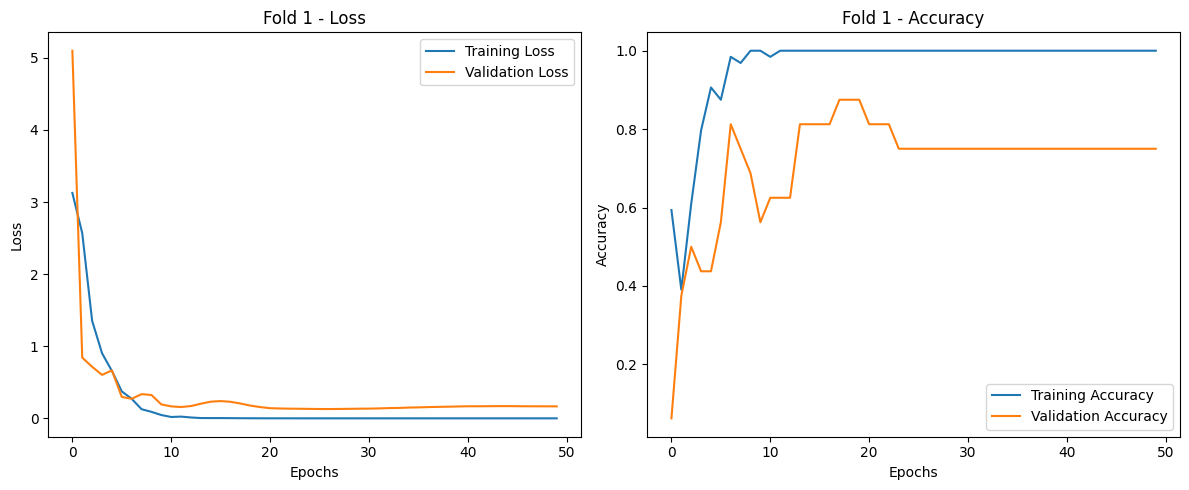

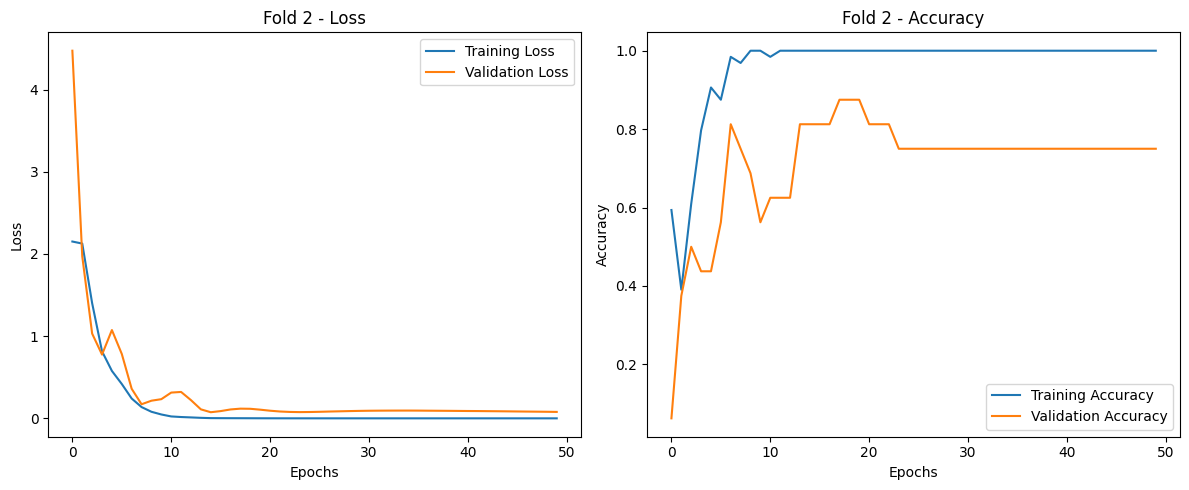

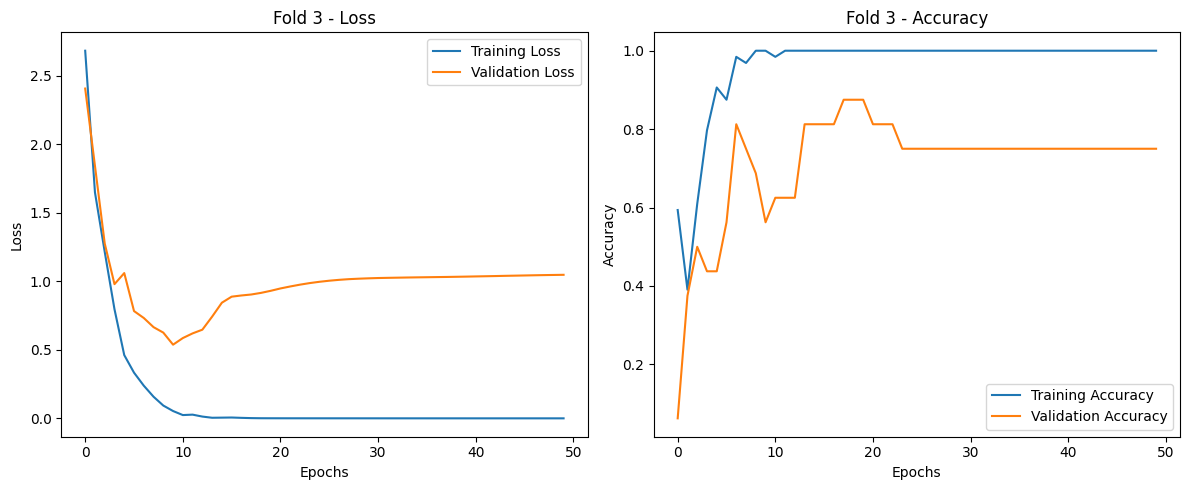

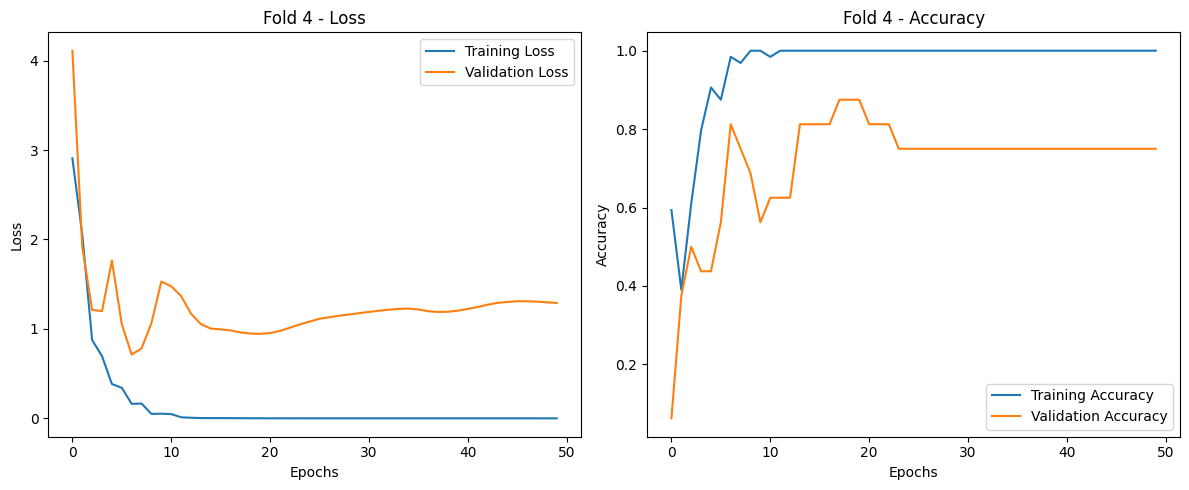

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

losses = []  # Add this array
val_losses = []

# Iterate through each fold
for fold_index in range(4):

    history_csv_path = f'/content/drive/MyDrive/Tharshini/Model16/Model'+str(fold_index+1)+'/history_fold_1.csv'
    history_df = pd.read_csv(history_csv_path)

    # Extract loss and val_loss columns from the history DataFrame
    loss_values = history_df['loss'].values
    val_loss_values = history_df['val_loss'].values

    # Append loss and val_loss to arrays
    losses.append(loss_values)
    val_losses.append(val_loss_values)

for fold_index in range(4):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(losses[fold_index], label='Training Loss')
    plt.plot(val_losses[fold_index], label='Validation Loss')
    plt.title(f'Fold {fold_index + 1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='Training Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold_index + 1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



